# Cognitive Modeling - Assignment 2
Yorick Juffer \
s1993623

## Libraries

In [35]:
import math
import random
from model import Model
from dmchunk import Chunk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Functions
Including the functions from previous assignment. In this scenario, b has been increased to allow for some more variability. 

In [36]:
t_0 = 0.011
a = 1.1
b = 0.15
add_noise = True

def noise(s):
    rand = random.uniform(0.001, 0.999)
    return s * math.log((1 - rand)/rand)

def time_to_pulses(time, t_0 = t_0, a = a, b = b, add_noise = add_noise):  
    pulses = 0
    pulse_duration = t_0
    
    while time >= pulse_duration:
        time = time - pulse_duration
        pulses = pulses + 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
        
    return pulses

def pulses_to_time(pulses, t_0 = t_0, a = a, b = b, add_noise = add_noise):
    time = 0
    pulse_duration = t_0
    
    while pulses > 0:
        time = time + pulse_duration
        pulses = pulses - 1
        pulse_duration = a * pulse_duration + add_noise * noise(b * a * pulse_duration)
    
    return time

## Experiment
Blending is used to run the experiment as it seems most appropriate for a time based experiment. In this function, the amount of participants (n) and trials (t) is given and will run each participant through all the trials. First a model is generated, one training run is included as to set up a past foreperiod, and then t trials are conducted.
 
During one trial, a random foreperiod is picked and an approximation is called up from memory. This is done via the pulses/time functions to be more inline with the internal metronome. The difference is calculated between the two, with the approximation being biassed towards times before an expected foreperiod (the pulses from memory is multiplied by 0.33). This was included to stimulate participants who actively wanted to improve somewhat, and it also had a very positive effect on the production of the graph.
 
After this, positive differences would get a discounted response time to reflect preparedness. The participant number, response time, foreperiod and past foreperiod are all saved.

In [37]:
def experiment(n, t):

    fore_period = [0.4, 0.8, 1.2, 1.6]

    for participant in range(n): 
        
        participant_model = Model()

        # train
        fore_period_rng = random.choice(fore_period)
        pulses = time_to_pulses(fore_period_rng)
        chunk = Chunk(name = "time" + str(participant), slots = {"type": "time", "value": pulses})
        participant_model.add_encounter(chunk)
        participant_model.time += 0.1

        pastFP = fore_period_rng

        # trials
        for trial in range(t):

            reaction_time = 0.410
            fore_period_rng = random.choice(fore_period)

            # pre stimulus
            blend_pattern = Chunk(name = "fore_period", slots = {"type": "time"})
            memory = participant_model.retrieve_blended_trace(blend_pattern, "value")

            difference = fore_period_rng - pulses_to_time(memory[0]  * 0.33)
            participant_model.time += memory[1] + 0.05
            
            if(difference >= 0.05):
                reaction_time =  reaction_time - 0.05
            elif(difference <= 0):
                reaction_time =  reaction_time
            else: 
                reaction_time =  reaction_time - difference

            currentFP = fore_period_rng

            if(participant == 0):
                results = np.array([[participant, reaction_time, currentFP, pastFP]])
            else:
                results = np.append(results, [[participant, reaction_time, currentFP, pastFP]], axis=0)

            pastFP = fore_period_rng
            
            # post stimulus
            pulses = time_to_pulses(fore_period_rng)
            chunk = Chunk(name = "time" + str(participant) + str(trial), slots = {"type": "time", "value": pulses})
            participant_model.add_encounter(chunk)
            participant_model.time += 0.1
            
            # simple printout to see progress.
            print("Participant: {}/{}".format(participant + 1, n), end="\r")

    return results

# runs the experiment and generates data.
data = experiment(50, 1000)
dataFrame = pd.DataFrame(data)
dataFrame.columns = ["pp", "RT", "FP", "FPp"]

# make a copy of the data and drop the participant number from that. 
df = dataFrame
df.drop('pp', inplace=True, axis=1)


## Data

           RT                              
FPp       0.4       0.8       1.2       1.6
FP                                         
0.4  0.364166  0.368698  0.371198  0.374960
0.8  0.361797  0.364011  0.366587  0.366146
1.2  0.360791  0.362544  0.364440  0.365531
1.6  0.361404  0.361757  0.362482  0.364003


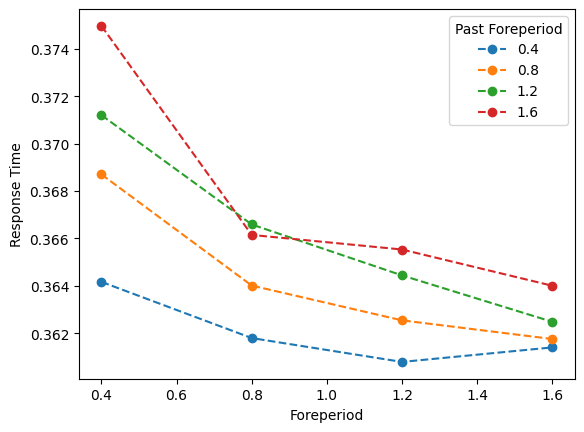

In [38]:
# Group the data by the FP and the past FP, then generate the graph.
grouped_df = df.groupby(["FP", "FPp"]).mean().unstack()
print(grouped_df)
plt.plot(grouped_df, linestyle='--', marker='o', label = ["0.4", "0.8", "1.2", "1.6"])
plt.legend(loc='upper right', title="Past Foreperiod")
plt.xlabel("Foreperiod")
plt.ylabel("Response Time")
plt.show()
